In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import ResonatorOptimizer as ro

plt.style.use('seaborn-deep')

In [2]:
# Global Parameters
__er = 11.9
__fo = 7.3e09
__h = 500e-06
__t = 50e-09
__pen_depth = 39e-09
__total_width = 80e-06
__total_width_max = 80e-06
__length = 8102.64e-06

__keyind = lambda X,X_array: min(enumerate(X_array), key=lambda x: abs(x[1]-X))

In [3]:
# Instantiate parameter sweep object
ps = ro.ParamSweeps(__length,__total_width,__fo,__er,__h,__t,__pen_depth)

# Sweep geometry to see effect on parameters of interest
minw, maxw, wit = [2, (__total_width*1e06)-1, 0.01]
# minw, maxw, wit = [2, 8, 0.01]
sweep_params = ps.width_to_gap(minw,maxw,wit=wit)
# ps.plot_params(sweep_params)

In [4]:
# Sweep the kinetic inductance in simulation
def sweep_Lk(width,length,total_width_max):
    tw_sweep = np.arange(width+0.1e-06,__total_width_max,2e-06)

    Lk = []
    gap = []
    total_width = []

    for i in range(len(tw_sweep)):
        total_width.append(tw_sweep[i])
        minw, maxw, wit = [width*1e06, (total_width[i]*1e06), 0.1]
        params = ps.width_to_gap(minw,maxw,wit=wit)
        gap = .5*(total_width[i] - width)
        cpw = ro.cpwCalcs(width,gap,length,__fo, __er, h=__h, t=__t, pen_depth=__pen_depth)
        Lk.append(cpw.Lk())

    dic = {'Lk':Lk, 'tw_sweep':tw_sweep, 'gap':gap, 'total_width':total_width}
    df = pd.DataFrame(data=dic)
    return df

In [6]:
tw = __total_width
cav_width = 4.00e-06
cav_gap = .5*(tw-cav_width)

highZ_width = 2.50e-06
highZ_gap = .5*(tw-highZ_width)

lowZ_width = 10.0e-06
lowZ_gap = .5*(tw-lowZ_width)

In [10]:
def get_effective_length(width,gap,target_freq,elen='hw',lstrt=2000,lstop=8000,lit=20000):

    length = np.linspace(lstrt, lstop, lit)*1e-06
    f0 = []

    for l in range(len(length)):
        cpw = ro.cpwCalcs(width, gap, length[l], __fo, __er, h=__h, t=__t, pen_depth=__pen_depth)
        if elen == 'hw':
            f0.append(1 / (2 * length[l]* np.sqrt(cpw.capacitance_per_length() * cpw.Ltotal() ) ))
        elif elen =='qw':
            f0.append(1 / (4 * length[l]* np.sqrt(cpw.capacitance_per_length() * cpw.Ltotal() ) ))
        else:
            raise ValueError('Electrical length not recognized. Choose either \'hw\' or \'qw\'')
    
    return length[np.abs(np.array(f0)*1e-09 - target_freq*1e-09).argmin()]

In [11]:
cav_length = get_effective_length(cav_width,cav_gap,__fo,elen='hw')
lowZ_length = get_effective_length(lowZ_width,lowZ_gap,__fo,elen='qw')
highZ_length = get_effective_length(highZ_width,highZ_gap,__fo,elen='qw',lstrt=1,lstop=6001)

In [12]:
cavity = ro.cpwCalcs(cav_width, cav_gap, cav_length, __fo, __er, h=__h, t=__t, pen_depth=__pen_depth)
Zlow = ro.cpwCalcs(lowZ_width, lowZ_gap, lowZ_length, __fo, __er, h=__h, t=__t, pen_depth=__pen_depth)
Zhigh = ro.cpwCalcs(highZ_width, highZ_gap, highZ_length, __fo, __er, h=__h, t=__t, pen_depth=__pen_depth)

In [13]:
cavity.phase_velocity()

48471430.37658282

In [15]:
.5*Zlow.phase_velocity()

48665186.306174055

In [16]:
.5*Zhigh.phase_velocity()

14042413.031043999

In [45]:
freq = np.linspace(2,12,60000)*1e09
freq_nb = np.linspace(7.2994,7.2996,1000)*1e09

# Instantiate bragg class
br = ro.Bragg(__fo,__er,__h,__t,__pen_depth)

# Specify bragg sections
bragg = br.bragg_resonator(freq,Zlow, Zhigh, cavity)
bragg_nb = br.bragg_resonator(freq_nb,Zlow, Zhigh, cavity)

rofit = ro.ResonatorFitting()
fit = rofit.LorentzianFit(freq_nb,bragg_nb,plot=False)
Q = fit.Q.values[0]
f0 = fit.centre.values[0]*1e06
fwhm = fit.out.values[0].params['fwhm'].value*1e-06

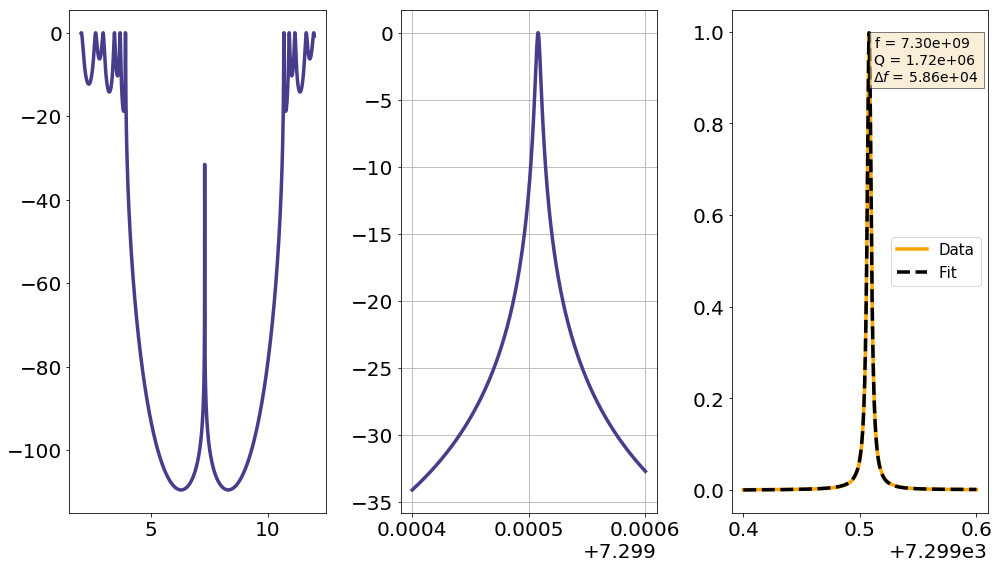

In [46]:
fig = plt.figure(figsize=(14,8))

ax0 = fig.add_subplot(131)
plt.plot(freq*1e-09,bragg,color = 'darkslateblue')

ax1 = fig.add_subplot(132)
plt.plot(freq_nb*1e-09,bragg_nb,color = 'darkslateblue')
plt.grid()

ax2 = fig.add_subplot(133)
plt.plot(fit.x,fit.y,color = 'orange', label = 'Data')
plt.plot(fit.x,fit.fit,'--',color = 'k',label = 'Fit')
plt.text(0.76, 0.9, 'f = {:.2e}  \nQ = {:.2e} \n$\Delta f$ = {:.2e} '.format(f0,Q,fwhm), horizontalalignment='center',
     verticalalignment='center', transform=ax2.transAxes,fontsize=14,bbox=dict(facecolor='wheat', alpha=0.5))
plt.legend(loc='center right')

plt.tight_layout()
plt.show()

In [47]:
1/(np.sqrt(cavity.Ltotal() * cavity.capacitance_per_length()))

48471430.37658282

In [49]:
1/(np.sqrt(Zlow.Ltotal() * Zlow.capacitance_per_length()))

97330372.61234811

In [50]:
1/(np.sqrt(Zhigh.Ltotal() * Zhigh.capacitance_per_length()))

28084826.062087998